## Dhaka Stock Exchange (DSE) Price prediction

Recently I have been working on time-series data a lot. I was thinking to get to know the very basics of LSTM. So, what can be better than trying to predict a stock price using LSTM. 

I have collected some data from [Dhaka Stock Exchange (DSE)][1]. The data were collected from their archive page. No csv export was available for downloading. I could only select dates and they generate the data as html. They have data until the year 2016. So, I tried to generate the data from 2016 until now but the website freezes when I try to generate so huge data. For that reason I ended up search and generate 3 set of data for 2016, 2017 and 2018. Later I saved the html files and parse the data and converted them into csv.

[1]: https://www.dsebd.org/

### Importing and initializations

In [55]:
from bs4 import BeautifulSoup
import traceback
from datetime import datetime
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

%matplotlib inline

In [2]:
ROOT_DIR = '/Users/sparrow/Learning/machine-learning/dse-prediction'
MODELS_DIR = os.path.join(ROOT_DIR, 'models')
DATASET_DIR = '/srv/downloads/moshfiqur-ml-datasets/dse'

### Data preparations

I have saved the data with name like `dse_data_2017.html`. We will loop over all the html files and put their content in a dictionary.

In [3]:
years = [2016, 2017, 2018]
html_content = {}

for year in years:
    with open(os.path.join(DATASET_DIR, 'raw', 'dse_data_{}.html'.format(year))) as f:
        html_content[year] = f.read()

In [4]:
len(html_content[2018])

86933558

All available columns in the data. Here are some explanations:
```
SERIAL: Just a serial number of the data.
DATE: Date of the data collected.
TRADING CODE: Company short code name.
LTP: Last trading price.
HIGH: Highest price in that day.
LOW: Lowest price in that day. 
OPENP: Open price in that day.
CLOSEP: Close price in that day.
YCP: Yesterday's closing price.
TRADE: Total number of share traded.
VALUE_MN: Total value in millions
VOLUME_ME: Total volume in millions
```

In [5]:
columns = ['SERIAL', 'DATE', 'TRADING CODE', 'LTP', 'HIGH', 'LOW', 
           'OPENP', 'CLOSEP', 'YCP', 'TRADE', 'VALUE_MN', 'VOLUME_MN']

### Parse the html files

In [6]:
data_list = []

for year, html in html_content.items():
    print('Processing data for the year {}'.format(year))
    
    soup = BeautifulSoup(html, 'lxml')
    
    # Remove and throw away all <script> tags and content from data
    _ = [s.extract() for s in soup('script')]
    print('Total {} script tags were removed'.format(len(_)))
    
    # Find all the tables, the 363th table is the 
    # original data table :D 
    tables = soup.find_all('table')
    if not tables[363]:
        print('Did not find the data table on index 363')
        break
    data_table = tables[363]
    
    # Loop through all the rows skipping the first one
    # as the first one contains the table header
    is_first = True
    for row in data_table.find_all('tr'):
        if is_first:
            is_first = False
            continue

        # Strip the comma's so we can treat them as numbers
        cells = [c.text.strip().replace(',', '') for c in row.find_all('td')]

        data_list.append(cells)
    
    is_first = True
    print('Data list length: {}'.format(len(data_list)))
    print('*'*10)

Processing data for the year 2016
Total 8 script tags were removed
Data list length: 67539
**********
Processing data for the year 2017
Total 8 script tags were removed
Data list length: 131530
**********
Processing data for the year 2018
Total 8 script tags were removed
Data list length: 209659
**********


### Convert the parsed data into DataFrame

In [7]:
df_orig = pd.DataFrame.from_records(data_list, columns=columns)

In [8]:
df_orig.head()

,SERIAL,DATE,TRADING CODE,LTP,HIGH,LOW,OPENP,CLOSEP,YCP,TRADE,VALUE_MN,VOLUME_MN
0,1,2016-12-29,1JANATAMF,5.8,6.2,5.8,6.2,5.9,6.2,443,26.409,4427760
1,2,2016-12-28,1JANATAMF,6.2,6.4,6,6.1,6.2,5.9,576,40.639,6503967
2,3,2016-12-27,1JANATAMF,5.9,5.9,5.4,5.4,5.9,5.4,385,32.014,5650124
3,4,2016-12-26,1JANATAMF,5.3,5.4,5.2,5.2,5.4,5.2,133,10.447,1966696
4,5,2016-12-22,1JANATAMF,5.2,5.3,5.1,5.1,5.2,5.1,111,9.652,1857034


In [9]:
if 'SERIAL' in df_orig.columns:
    df_orig.drop(['SERIAL'], axis=1, inplace=True)

Fixing a weird missing string NoneType value problem in HIGH column

In [10]:
df_orig['HIGH'].fillna(0, inplace=True)
df_orig['TRADE'].fillna(0, inplace=True)
df_orig['VOLUME_MN'].fillna(0, inplace=True)

high_values = []
for value in df_orig['HIGH']:
    try:
        high_values.append(float(value))
    except ValueError:
        high_values.append(0.0)
        continue

df_orig['HIGH'] = high_values

trade_values = []
for value in df_orig['TRADE']:
    try:
        trade_values.append(float(value))
    except ValueError:
        trade_values.append(0)
        continue

df_orig['TRADE'] = trade_values

volume_values = []
for value in df_orig['VOLUME_MN']:
    try:
        volume_values.append(float(value))
    except ValueError:
        volume_values.append(0)
        continue

df_orig['VOLUME_MN'] = volume_values

Converting the data into their appropriate data types

In [11]:
df_orig[['LTP']] = df_orig[['LTP']].astype(float)
df_orig['HIGH'] = df_orig['HIGH'].astype(float)
df_orig[['LOW']] = df_orig[['LOW']].astype(float)
df_orig[['OPENP']] = df_orig[['OPENP']].astype(float)
df_orig[['CLOSEP']] = df_orig[['CLOSEP']].astype(float)
df_orig[['YCP']] = df_orig[['YCP']].astype(float)
df_orig[['VALUE_MN']] = df_orig[['VALUE_MN']].astype(float)

df_orig[['DATE']] = df_orig[['DATE']].astype(datetime)

df_orig['TRADE'] = df_orig['TRADE'].astype(int)
df_orig['VOLUME_MN'] = df_orig['VOLUME_MN'].astype(int)

In [12]:
df_orig.shape

(209659, 11)

In [13]:
df_orig.dtypes

DATE             object
TRADING CODE     object
LTP             float64
HIGH            float64
LOW             float64
OPENP           float64
CLOSEP          float64
YCP             float64
TRADE             int64
VALUE_MN        float64
VOLUME_MN         int64
dtype: object

There are some junk instrument names which has always 0 values. We won't consider them

In [14]:
df_orig = df_orig[(df_orig['LTP'] > 0) & 
                  (df_orig['HIGH'] > 0) & 
                  (df_orig['LOW'] > 0) & 
                  (df_orig['OPENP'] > 0)]

Lets check the dataframe shapes after dropping unnecessary rows

In [15]:
df_orig.shape

(176848, 11)

In [16]:
df_orig.head()

,DATE,TRADING CODE,LTP,HIGH,LOW,OPENP,CLOSEP,YCP,TRADE,VALUE_MN,VOLUME_MN
0,2016-12-29,1JANATAMF,5.8,6.2,5.8,6.2,5.9,6.2,443,26.409,4427760
1,2016-12-28,1JANATAMF,6.2,6.4,6.0,6.1,6.2,5.9,576,40.639,6503967
2,2016-12-27,1JANATAMF,5.9,5.9,5.4,5.4,5.9,5.4,385,32.014,5650124
3,2016-12-26,1JANATAMF,5.3,5.4,5.2,5.2,5.4,5.2,133,10.447,1966696
4,2016-12-22,1JANATAMF,5.2,5.3,5.1,5.1,5.2,5.1,111,9.652,1857034


### Save the dataframe as csv

In [17]:
if False:
    df_orig.to_csv(os.path.join(DATASET_DIR, 'processed', 'data.csv'), index=False)

In [18]:
df_companies = pd.DataFrame(df_orig['TRADING CODE'].unique(), columns=['TRADING CODE'])

In [19]:
df_companies.head()

,TRADING CODE
0,1JANATAMF
1,1STPRIMFMF
2,3RDICB
3,4THICB
4,5THICB


In [20]:
if False:
    df_companies.to_csv(os.path.join(DATASET_DIR, 'processed', 'companies.csv'), index=False)

### Load data from csv

In [21]:
df = pd.read_csv(os.path.join(DATASET_DIR, 'processed', 'data.csv'), encoding='utf-8', low_memory=False)
df_companies = pd.read_csv(os.path.join(DATASET_DIR, 'processed', 'companies.csv'), encoding='utf-8', low_memory=False)

In [22]:
df.head()

,DATE,TRADING CODE,LTP,HIGH,LOW,OPENP,CLOSEP,YCP,TRADE,VALUE_MN,VOLUME_MN
0,2016-12-29,1JANATAMF,5.8,6.2,5.8,6.2,5.9,6.2,443,26.409,4427760
1,2016-12-28,1JANATAMF,6.2,6.4,6.0,6.1,6.2,5.9,576,40.639,6503967
2,2016-12-27,1JANATAMF,5.9,5.9,5.4,5.4,5.9,5.4,385,32.014,5650124
3,2016-12-26,1JANATAMF,5.3,5.4,5.2,5.2,5.4,5.2,133,10.447,1966696
4,2016-12-22,1JANATAMF,5.2,5.3,5.1,5.1,5.2,5.1,111,9.652,1857034


In [23]:
df_companies.head()

,TRADING CODE
0,1JANATAMF
1,1STPRIMFMF
2,3RDICB
3,4THICB
4,5THICB


### Data selection and clean up

We will select here one single company to predict their closing price.

In [24]:
df = df[df['TRADING CODE'] == 'BRACBANK']

In [25]:
df.shape

(651, 11)

In [26]:
df.head()

,DATE,TRADING CODE,LTP,HIGH,LOW,OPENP,CLOSEP,YCP,TRADE,VALUE_MN,VOLUME_MN
13659,2016-12-29,BRACBANK,64.0,64.3,63.9,64.2,64.1,64.2,395,73.923,1152870
13660,2016-12-28,BRACBANK,64.3,64.8,64.0,64.3,64.2,64.3,335,81.314,1266000
13661,2016-12-27,BRACBANK,64.5,64.8,64.3,64.3,64.3,64.3,256,31.864,494156
13662,2016-12-26,BRACBANK,64.2,64.5,63.9,63.9,64.3,64.5,220,36.809,572591
13663,2016-12-22,BRACBANK,64.8,64.9,64.1,64.9,64.5,64.9,276,39.014,603809


Convert the `DATE` column into datetime format, sort the values by datetime and then set this as index.

In [27]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df.sort_values('DATE', inplace=True)
df.set_index('DATE', inplace=True)

In [28]:
df.head()

,TRADING CODE,LTP,HIGH,LOW,OPENP,CLOSEP,YCP,TRADE,VALUE_MN,VOLUME_MN
DATE,,,,,,,,,,
2016-01-03,BRACBANK,48.5,49.8,48.5,49.8,48.5,48.7,115,6.511,134072
2016-01-04,BRACBANK,48.3,48.5,47.5,48.5,48.0,48.5,99,12.686,264322
2016-01-05,BRACBANK,48.1,48.5,47.5,47.5,48.1,48.0,135,8.443,175746
2016-01-06,BRACBANK,47.5,48.4,47.1,48.0,47.3,48.1,190,10.302,216460
2016-01-07,BRACBANK,47.5,47.7,47.1,47.2,47.5,47.3,193,23.958,504788


Lets check out some data rows

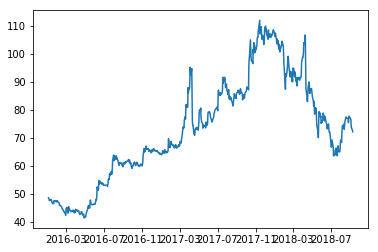

In [29]:
plt.plot(df['LTP'])

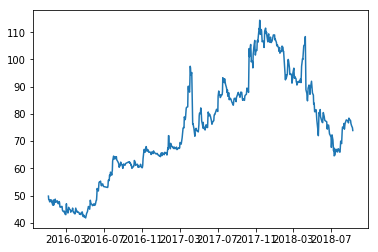

In [30]:
plt.plot(df['HIGH'])

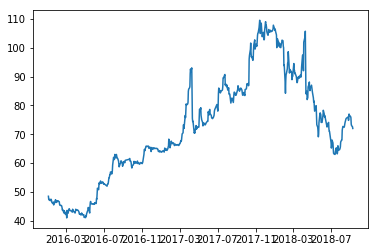

In [31]:
plt.plot(df['LOW'])

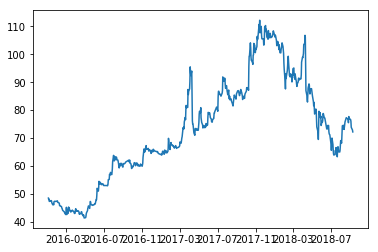

In [201]:
plt.plot(df['CLOSEP'])

### Data selection and processing

In [33]:
df = df[['CLOSEP']]

In [34]:
df.head()

,CLOSEP
DATE,
2016-01-03,48.5
2016-01-04,48.0
2016-01-05,48.1
2016-01-06,47.3
2016-01-07,47.5


The dataset has observation for each day. We want to predict the close price for next day. Hence we will shift the data 1 day in the future.

In [35]:
shift_steps = 1 # by day

In [36]:
df_shifted = df.shift(-shift_steps)

In [37]:
df_shifted.head()

,CLOSEP
DATE,
2016-01-03,48.0
2016-01-04,48.1
2016-01-05,47.3
2016-01-06,47.5
2016-01-07,47.4


In [202]:
df_shifted.tail()

,CLOSEP
DATE,
2018-09-04,73.9
2018-09-05,73.6
2018-09-06,72.9
2018-09-09,72.2
2018-09-10,NaN


As expected, the last row in the `df_shifted` dataframe has value NaN as we shift it upward direction.

We will now convert the pandas dataframe into numpy arrays so that it can be input into the neural network. We will not consider the last `shift_steps` number of rows in the original dataframe. Because, in the shifted dataframe, those rows contains NaN. Those NaN will produce errors as they are not valid data. Also, we need to have same shape for input and output data.

In [39]:
target_names = ['CLOSEP']

data_train = df.values[0:-shift_steps]
data_target = df_shifted.values[0:-shift_steps]

data_train.shape, data_target.shape

((650, 1), (650, 1))

In [40]:
# Number of observations
num_data = len(data_train)

# Percentage of dataset that will be used for training
train_split = 0.9

# Number of observations in the training set
num_train = int(train_split * num_data)

# Number of observation in the test set
num_test = num_data - num_train

# Samples for train and test dataset
X_train_orig = data_train[0:num_train]
X_test_orig = data_train[num_train:]

y_train_orig = data_target[0:num_train]
y_test_orig = data_target[num_train:]

X_train_orig.shape, y_train_orig.shape, X_test_orig.shape, y_test_orig.shape

((585, 1), (585, 1), (65, 1), (65, 1))

In [41]:
# number of input values
# 2, one for temperature and 
# another for humidity
# TODO should be input_shape
input_shape = X_train_orig.shape[1]

# number of output values
# 2, one for temperature and 
# another for humidity
# TODO should be output_shape
output_shape = y_train_orig.shape[1]

input_shape, output_shape

(1, 1)

### Data normalization

Lets have a look at the data range before normalization

In [203]:
print('Min X_train_orig:', np.min(X_train_orig))
print('Max X_train_orig:', np.max(X_train_orig))
print('Min y_train_orig:', np.min(y_train_orig))
print('Max y_train_orig:', np.max(y_train_orig))
print('Min X_test_orig:', np.min(X_test_orig))
print('Max X_test_orig:', np.max(X_test_orig))
print('Min y_test_orig:', np.min(y_test_orig))
print('Max y_test_orig:', np.max(y_test_orig))

Min X_train_orig: 41.4
Max X_train_orig: 112.2
Min y_train_orig: 41.4
Max y_train_orig: 112.2
Min X_test_orig: 63.3
Max X_test_orig: 78.8
Min y_test_orig: 63.3
Max y_test_orig: 78.8


In [204]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train_orig)
X_test = x_scaler.transform(X_test_orig)

In [205]:
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train_orig)
y_test = y_scaler.transform(y_test_orig)

Data after normaliztion

In [206]:
print('Min X_train:', np.min(X_train))
print('Max X_train:', np.max(X_train))
print('Min y_train:', np.min(y_train))
print('Max y_train:', np.max(y_train))
print('Min X_test:', np.min(X_test))
print('Max X_test:', np.max(X_test))
print('Min y_test:', np.min(y_test))
print('Max y_test:', np.max(y_test))

Min X_train: 0.0
Max X_train: 0.9999999999999999
Min y_train: 0.0
Max y_train: 0.9999999999999999
Min X_test: 0.30932203389830504
Max X_test: 0.5282485875706214
Min y_test: 0.30932203389830504
Max y_test: 0.5282485875706214


In [207]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((585, 1), (585, 1), (65, 1), (65, 1))

### Train the model

The LSTM implementation is inspired by Siraj Raval's youtube video tutorial and the related jupyter notebook here from this [github repo][2].

[2]: https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo

In [295]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        X_shape = (batch_size, sequence_length, input_shape)
        X_batch = np.zeros(shape=X_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, output_shape)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            X_batch[i] = X_train[idx:idx+sequence_length]
            y_batch[i] = y_train[idx:idx+sequence_length]
        
        yield (X_batch, y_batch)

def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train
        y_true = y_train_orig
    else:
        # Use test-data.
        x = X_test
        y_true = y_test_orig
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    
    # Use the model to predict the output-signals.
    y_pred = model.predict(x).reshape(y_true.shape[0], 1)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    
    warmup_steps = 10
    
    # For each output-signal.
    for signal in range(output_shape):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [208]:
batch_size = 32
sequence_length = 7

In [209]:
# Create the batch generator
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [210]:
validation_data = (np.expand_dims(X_test, axis=0),
                   np.expand_dims(y_test, axis=0))

In [271]:
model = Sequential()

In [272]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(None, input_shape,)))

In [273]:
model.add(LSTM(units=100, return_sequences=True, input_shape=(None, input_shape,)))

In [274]:
model.add(Dense(output_shape, activation='sigmoid'))

In [276]:
# We then compile the Keras model so it is ready for training.
model.compile(loss='mse', optimizer='rmsprop')

In [277]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, None, 50)          10400     
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 100)         60400     
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [278]:
path_checkpoint = 'checkpoint_1.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [279]:
# This is the callback for stopping the optimization when performance worsens on the validation-set.
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [280]:
# This is the callback for writing the TensorBoard log during training.
callback_tensorboard = TensorBoard(log_dir='logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [282]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard]

In [283]:
# The main training process, when need to train a new 
# model, change if condition to True
if True:
    %%time
    model.fit_generator(generator=generator,
                        epochs=20,
                        steps_per_epoch=100,
                        validation_data=validation_data,
                        callbacks=callbacks)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
Epoch 1/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.0288
Epoch 00001: val_loss improved from inf to 0.00528, saving model to checkpoint_1.keras
100/100 [==============================] - 6s 60ms/step - loss: 0.0280 - val_loss: 0.0053
Epoch 2/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.0064
Epoch 00002: val_loss improved from 0.00528 to 0.00189, saving model to checkpoint_1.keras
100/100 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 3/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00003: val_loss improved from 0.00189 to 0.00075, saving model to checkpoint_1.keras
100/100 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 7.4703e-04
Epoch 4/20
 96/100 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 00004: val_loss did not improve from 0.00075
100/100 [======================

In [284]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [285]:
result = model.evaluate(x=np.expand_dims(X_test, axis=0),
                        y=np.expand_dims(y_test, axis=0))

1/1 [==============================] - 0s 18ms/step


In [286]:
print("loss (test-set):", result)

loss (test-set): 0.0007470314158126712


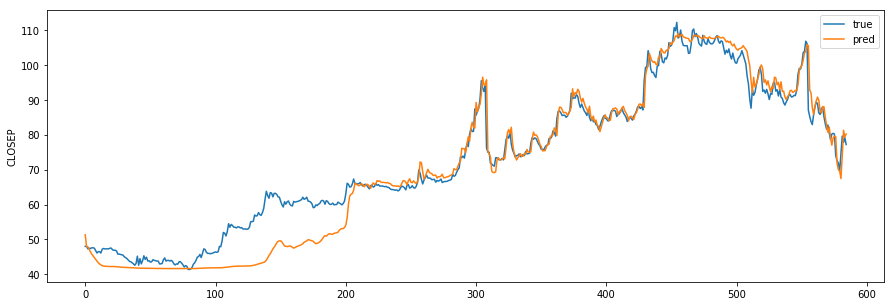

In [296]:
plot_comparison(start_idx=0, length=650, train=True)

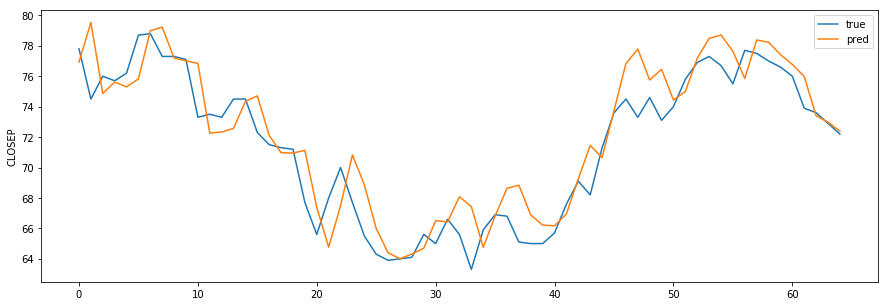

In [297]:
plot_comparison(start_idx=0, length=65, train=False)

Looking at the graphs above, we can see that during the beginning of training, the output was not very good. But after 200th data sequence, it started to get better. Arond the end, it gets really better. Also, when we tested the model using test data, the prediction looks promising.